     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Paste YouTube video link: https://youtu.be/hIzZm4CPem4?si=ZdPfDlZbOuEBya9m
[youtube] Extracting URL: https://youtu.be/hIzZm4CPem4?si=ZdPfDlZbOuEBya9m
[youtube] hIzZm4CPem4: Downloading webpage


[youtube] hIzZm4CPem4: Downloading android vr player API JSON
[info] hIzZm4CPem4: Downloading 1 format(s): 18
[download] Destination: video.mp4
[download] 100% of    1.35MiB in 00:00:00 at 7.87MiB/s   


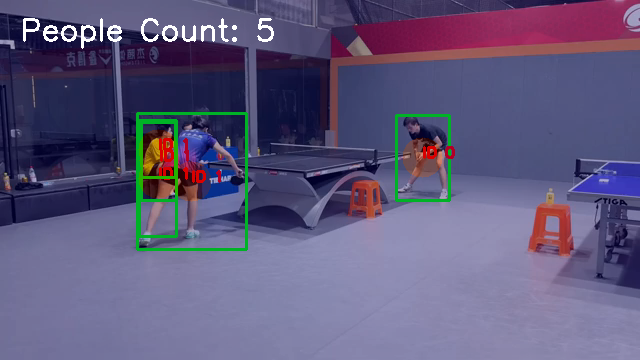

Processing frame: 0
Processing frame: 100
Processing frame: 200


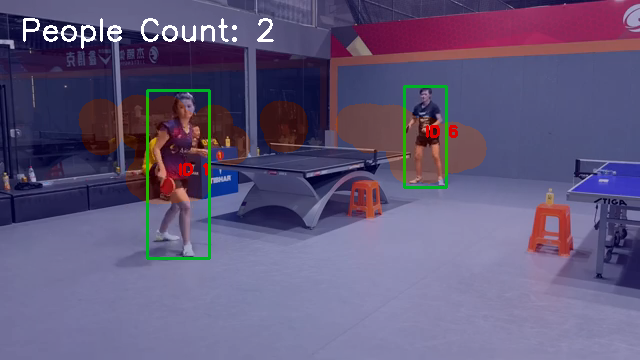

Processing frame: 300
Processing frame: 400
Processing frame: 500


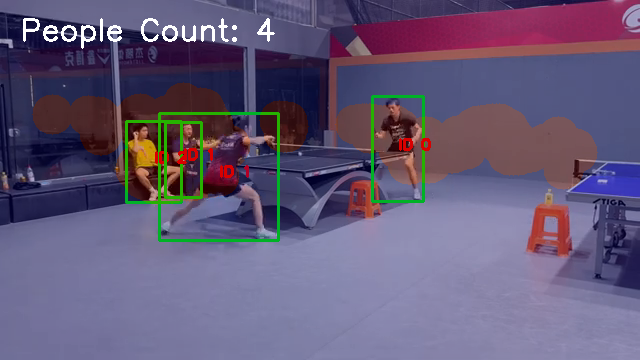

Processing frame: 600
Processing frame: 700
Processing frame: 800


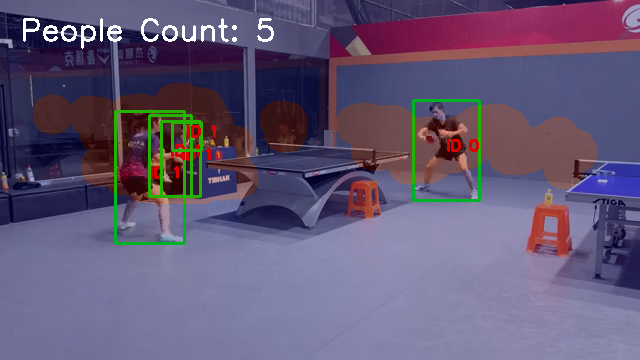

Processing frame: 900
Processing frame: 1000

✅ Processing complete!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# =====================================
# Install libraries
# =====================================
!pip -q install ultralytics opencv-python-headless yt-dlp

# =====================================
# Imports
# =====================================
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from google.colab import files
import yt_dlp

# =====================================
# Enter YouTube URL
# =====================================
url = input("Paste YouTube video link: ")

# =====================================
# Download video
# =====================================
ydl_opts = {
    'format': 'mp4',
    'outtmpl': 'video.mp4'
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])

video_path = "video.mp4"

# =====================================
# Load detection model
# =====================================
model = YOLO("yolov8n.pt")

# =====================================
# Video setup
# =====================================
cap = cv2.VideoCapture(video_path)

width = int(cap.get(3))
height = int(cap.get(4))
fps = max(1, int(cap.get(cv2.CAP_PROP_FPS)))

out = cv2.VideoWriter(
    "analytics_output.mp4",
    cv2.VideoWriter_fourcc(*'mp4v'),
    fps,
    (width, height)
)

# =====================================
# Heatmap + tracking
# =====================================
heatmap = np.zeros((height, width), dtype=np.float32)

tracks = {}
next_id = 0

def centroid(box):
    x1,y1,x2,y2 = box
    return int((x1+x2)/2), int((y1+y2)/2)

def match_object(c):
    global next_id
    for obj_id, prev in tracks.items():
        if np.linalg.norm(np.array(c)-np.array(prev)) < 50:
            return obj_id
    tracks[next_id] = c
    next_id += 1
    return next_id-1

# =====================================
# Preview control (IMPORTANT)
# =====================================
MAX_PREVIEWS = 5           # only show 5 images
preview_interval = 300     # frame gap
preview_count = 0
frame_count = 0

# =====================================
# Processing loop
# =====================================
while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        break

    people_count = 0

    results = model(frame, verbose=False)

    for r in results:
        for box in r.boxes.data:

            x1,y1,x2,y2,conf,cls = box.tolist()
            cls = int(cls)

            if cls == 0:  # person class
                people_count += 1

                c = centroid((x1,y1,x2,y2))
                obj_id = match_object(c)
                tracks[obj_id] = c

                cv2.circle(heatmap, c, 20, 1, -1)

                cv2.rectangle(frame,(int(x1),int(y1)),
                              (int(x2),int(y2)),(0,255,0),2)

                cv2.putText(frame,f"ID {obj_id}",c,
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,(0,0,255),2)

    # Heatmap overlay
    hm = cv2.normalize(heatmap,None,0,255,cv2.NORM_MINMAX)
    hm = hm.astype(np.uint8)
    hm_color = cv2.applyColorMap(hm, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(frame,0.7,hm_color,0.3,0)

    cv2.putText(overlay,f"People Count: {people_count}",
                (20,40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,(255,255,255),2)

    out.write(overlay)

    # ⭐ Show only key preview frames
    if frame_count % preview_interval == 0 and preview_count < MAX_PREVIEWS:

        small = cv2.resize(overlay,(640,360))
        cv2_imshow(small)

        # save snapshot externally
        cv2.imwrite(f"snapshot_{preview_count}.jpg", overlay)

        preview_count += 1

    # progress update
    if frame_count % 100 == 0:
        print("Processing frame:", frame_count)

    frame_count += 1

# =====================================
# Cleanup
# =====================================
cap.release()
out.release()

print("\n✅ Processing complete!")

# =====================================
# Download results
# =====================================
files.download("analytics_output.mp4")
